<a href="https://colab.research.google.com/github/vinayak-7569/CUSTOMER-CHURN-PREDICTION/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Column Names: Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
✅ Detected and renamed 'Exited' to 'Churn'


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:25:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression Accuracy: 0.7815
Random Forest Accuracy: 0.85
XGBoost Accuracy: 0.836


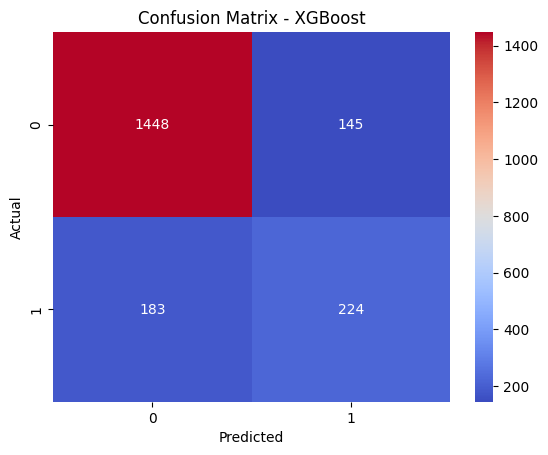

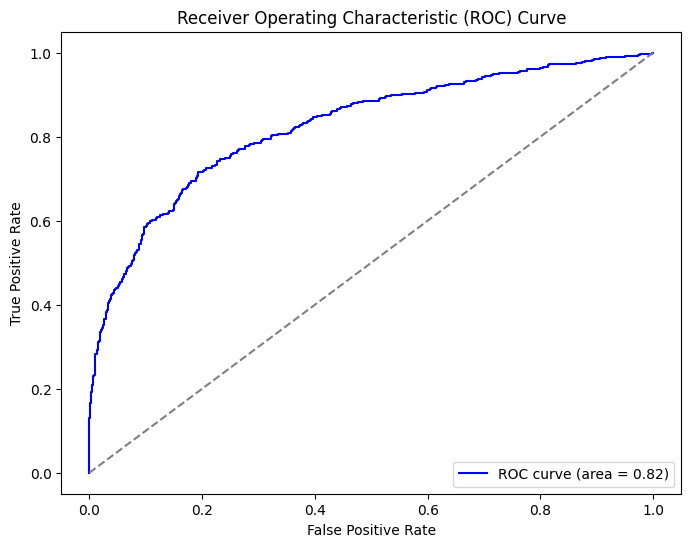

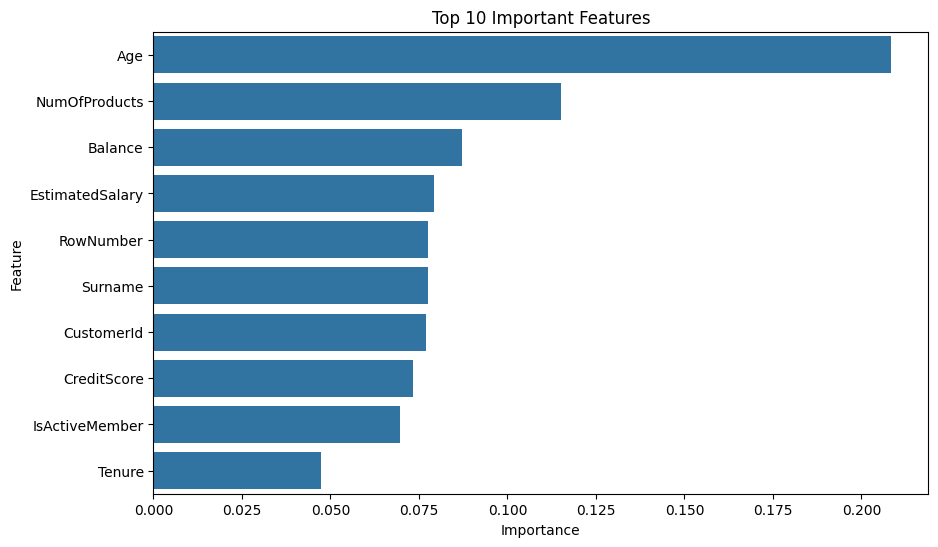

In [7]:
 # Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

# ✅ Load dataset
url = "/content/Churn_Modelling.csv"  # Ensure the correct file path
df = pd.read_csv(url)

# ✅ Fix column names (strip spaces)
df.columns = df.columns.str.strip()

# ✅ Print column names to check if 'Churn' exists
print("Column Names:", df.columns)

# ✅ Automatically detect the churn column
possible_churn_names = ['Churn', 'churn', 'Exited', 'Target', 'Customer Status']
found_churn = None

for col in df.columns:
    if col.strip() in possible_churn_names:
        found_churn = col.strip()
        df.rename(columns={col: 'Churn'}, inplace=True)
        print(f"✅ Detected and renamed '{col}' to 'Churn'")
        break

# ✅ If still not found, raise an error
if 'Churn' not in df.columns:
    raise ValueError("❌ 'Churn' column not found! Check your dataset column names.")

# ✅ Drop unnecessary columns
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# ✅ Convert 'TotalCharges' to numeric if it exists
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# ✅ Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# ✅ Encode categorical features
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# ✅ Split features and target
X = df.drop(columns=['Churn'])
y = df['Churn']

# ✅ Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# ✅ Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Train Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# ✅ Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train, y_train)

# ✅ Train XGBoost model (with GPU support if available)
xgb_model = XGBClassifier(n_estimators=100, tree_method='auto', use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# ✅ Predictions
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# ✅ Evaluate models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# ✅ Confusion Matrix for XGBoost
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ✅ Plot ROC Curve for XGBoost
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# ✅ Feature Importance (Random Forest)
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(10))
plt.title("Top 10 Important Features")
plt.show()
